## Presentación

En esta instancia decidimos trabajar sobre un dataset acerca de Objetos Ceranos a la Tierra, NEO's por sus siglas en inglés (Near Earth Objects), y poder predecir si un cuerpo dado representa un peligro de impacto con la Tierra. Pero nos encontramos con una peculiaridad; el dataset está desbalanceado respecto a nuestra columna de interés a predecir. Esto significa que antes de poder aplicar alogritmos con fin de predicción, debemos hacernos cargo de este problema.

A lo largo de nuestro análisis, el enfoque con más peso será buscar la solución a esta problemática, aplicando distintas herramientas y evaluando su desempeño a través de distintas métricas y comparando una a una, así poder llegar a una conlusión sobre cuál método fue el más beneficioso para la performance del algoritmo predictivo, además de poder ejemplificar por que tener un dataset desbalanceado presenta problemas a la hora de predecir.

### Objetivo general

- Evaluar como solucionar la problemática de que el dataset está desbalanceado respecto a la columna de interés a predecir
- Exponer los problemas que un dataset representa para el poder predictivo de un algoritmo


### Objetivos secundarios
- Analizar el dataset, buscar correlaciones entre variables y transformar datos
- Aplicar algoritmos de clasificacion para determinar si un NEO tiene peligro potencial de impacto

### Diccionario de datos:

- Unnamed: 0: Default index

- id: A unique ID given by NASA

- neo_reference_id: A unique ID given by NASA to all NEO, same as the ID

- name: Official name given by NASA

- name_limited: Normal name without the scientific notations

- designation: The number used in the official name given by NASA

- absolute_magnitude_h: Absolute magnitude (M) is a measure of the luminosity of a celestial object, on an inverse logarithmic astronomical

- is_potentially_hazardous_asteroid: Boolean value which tells if the object poses a threat to earth or not

- is_sentry_object: Boolean value which tells if the object is present in the sentry tracking system or not (Sentry: https://en.wikipedia.org/wiki/Sentry_(monitoring_system))

- kilometers_estimated_diameter_min: Minimum estimated diameter in kilometer

- kilometers_estimated_diameter_max: Maximum estimated diameter in kilometer

- orbit_id: A unique ID for the orbit of the object

- orbit_class_type: Classification of the object orbit into classes

    - (AMO is referring to Amor asteroids: near-Earth asteroids. The orbital perihelion of these objects is close to, but greater than, the orbital aphelion of Earth (a > 1.0 AU and 1.017 AU < q < 1.3 AU).

    - APO is referring to Apollo asteroids: near-Earth asteroid orbits which cross the Earth's orbit (a > 1.0 AU and q < 1.017 AU).)

    - (Abajo hay mas info sobre el tema, incluyendo las orbitas de tipo ATE e IEO)

- perihelion_distance: Has the perihelion distance (the point nearest to the Earth in the path of an orbiting celestial body)

- aphelion_distance: Has the aphelion distance (the point in the orbit of a planet, asteroid, or object at which it is furthest from the Earth)

- first_observation_date: Date when the object was first observed

- last_observation_date: Date when the object was last observed

- orbit_class_description: The description of the orbit

(Diccionario extrído de la fuente)

#### Más información sobre la clasificación de órbita

Asteroids are dynamically classified as "Near-Earth" if their perihelion distance is less than 1.3 AU. They are further divided into groups based on their semi-major axis (a), perihelion distance (q), and aphelion distance (Q).

- Apollos (APO) cross Earth's orbit and have a semi-major axis of more than 1 AU

- Amors (AMO) have orbits strictly outside Earth's orbit

- Atens (ATE) cross Earth's orbit and have a semi-major axis of less than 1 AU

- Atiras (IEO) have orbits strictly inside Earth's orbit

(Fuente: https://www.comet-toolbox.com/neos.html)

In [114]:
# Fuente: https://www.kaggle.com/datasets/adityaramachandran27/nasa-near-earth-objects-information

In [115]:
!pip install --upgrade pip
!pip install -r ../requirements.txt

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [117]:
# !unzip ../data/nasa_neo.zip
# !mv nasa_neo.csv ../data

In [118]:
df_raw = pd.read_csv('../data/nasa_neo.csv')

In [119]:
# info del dataset

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         24000 non-null  int64  
 1   id                                 24000 non-null  int64  
 2   neo_reference_id                   24000 non-null  int64  
 3   name                               24000 non-null  object 
 4   name_limited                       144 non-null    object 
 5   designation                        24000 non-null  object 
 6   absolute_magnitude_h               23992 non-null  float64
 7   is_potentially_hazardous_asteroid  24000 non-null  bool   
 8   is_sentry_object                   24000 non-null  bool   
 9   kilometers_estimated_diameter_min  23992 non-null  float64
 10  kilometers_estimated_diameter_max  23992 non-null  float64
 11  orbit_id                           24000 non-null  obj

Observar que hay datos faltantes en columnas como 'absolute_magnitude_h ' y 'name_limited'. En el segundo caso es porque NASA no le asigna nombres propios a todos los cuerpos

In [120]:
# Drop de columna Unnamed (index de sobra)

df_raw.drop(columns = ['Unnamed: 0'], inplace = True)

In [121]:
df_raw.describe()

,id,neo_reference_id,absolute_magnitude_h,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,perihelion_distance,aphelion_distance
count,2.400000e+04,2.400000e+04,23992.000000,23992.000000,23992.000000,24000.000000,24000.000000
mean,7.275111e+06,7.275111e+06,22.942274,0.167777,0.375160,0.915225,2.653104
std,1.333987e+07,1.333987e+07,2.952871,0.293000,0.655169,0.232201,4.468233
min,2.001981e+06,2.001981e+06,12.580000,0.000609,0.001362,0.070431,0.653754
25%,3.409962e+06,3.409962e+06,20.650000,0.024241,0.054205,0.785150,1.706281
50%,3.703790e+06,3.703790e+06,23.200000,0.060891,0.136157,0.965325,2.480109
75%,3.803897e+06,3.803897e+06,25.200000,0.197040,0.440595,1.068984,3.397965
max,5.408749e+07,5.408749e+07,33.200000,8.101305,18.115068,1.299988,631.895456


In [122]:
df_raw.describe(include = ['object','bool'])

,name,name_limited,designation,is_potentially_hazardous_asteroid,is_sentry_object,orbit_id,orbit_class_type,first_observation_date,last_observation_date,orbit_class_description
count,24000,144,24000,24000,24000,24000,24000,24000,24000,24000
unique,24000,144,24000,2,2,352,4,5964,5016,4
top,1981 Midas (1973 EA),Midas,1981,False,False,7,APO,2014-04-23,2022-04-15,Near-Earth asteroid orbits which cross the Ear...
freq,1,1,1,21906,22934,1485,13245,67,40,13245


Podemos ver que la asignacion de nombres por parte de la NASA es unica, ya que en las columnas 'name', 'name_limited' y 'designation' tenemos todos valores unicos. Vamos a chequear tambien en la columna 'id' si se cumple

In [123]:
df_raw['id'].duplicated().any()

False

In [124]:
df_raw.sample(5)

,id,neo_reference_id,name,name_limited,designation,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_id,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
22450,54016459,54016459,(2020 GZ),NaN,2020 GZ,27.0,False,False,0.010582,0.023661,2,APO,0.674673,2.873541,2020-04-02,2020-04-04,Near-Earth asteroid orbits which cross the Ear...
8736,3596494,3596494,(2012 BY61),NaN,2012 BY61,26.4,False,False,0.013949,0.031192,5,AMO,1.049501,2.317599,2012-01-26,2012-01-27,Near-Earth asteroid orbits similar to that of ...
11242,3674070,3674070,(2014 MY26),NaN,2014 MY26,22.0,False,False,0.105817,0.236614,21,AMO,1.024095,3.090050,2014-06-24,2017-11-19,Near-Earth asteroid orbits similar to that of ...
3495,3102719,3102719,(2001 YB5),NaN,2001 YB5,20.9,True,False,0.175612,0.392681,7,APO,0.317088,4.360044,2001-12-26,2002-01-06,Near-Earth asteroid orbits which cross the Ear...
4347,3267343,3267343,(2005 CP38),NaN,2005 CP38,23.7,False,False,0.048368,0.108153,11,APO,0.672019,1.363136,2005-02-09,2005-02-17,Near-Earth asteroid orbits which cross the Ear...


#### Observaciones

- Las columnas 'id' y 'neo_reference_id' son identicas, asi que nos podemos quedar solo con una de ellas
- La columna 'name_limited' es simplemente la extraccion del nombre propio del cuerpo (si es que lo tiene), dato que ya esta en la columna 'name', por lo que no nos presenta informacion relevante, mas alla de sacar la proporcion de cuerpos a los que la NASA le ha asignado un valor propio. 
- Algo similar sucede con la columna 'designation', la cual tambien es una parte del nombre oficial establecido, y el dato completo del nombre esta en la columna 'name'

In [125]:
df_raw.drop(columns = ['neo_reference_id', 'name_limited', 'designation'], inplace = True)

## EDA

In [126]:
y = df_raw['is_potentially_hazardous_asteroid']
X = df_raw.drop(columns = ['is_potentially_hazardous_asteroid'])

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8,stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,stratify=y_rem, random_state=42)

# Para trabajar en el eda
X_united = pd.concat([X_train, X_valid])
y_united = pd.concat([y_train, y_valid])
df_united = pd.concat([X_united, y_united], axis=1)

### Distribución de variables categoricas

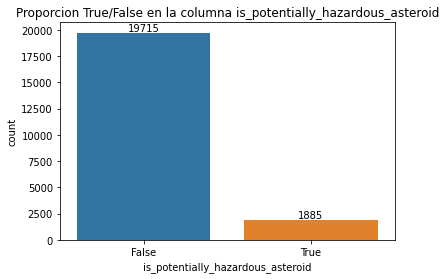

In [127]:
# is_potentially_hazardous_asteroid

ax = sns.countplot(x = df_united['is_potentially_hazardous_asteroid'])
ax.bar_label(ax.containers[0])
plt.title('Proporcion True/False en la columna is_potentially_hazardous_asteroid')
plt.show()

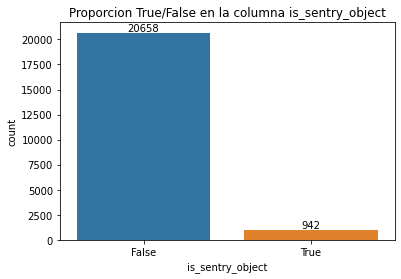

In [128]:
# is_sentry_object

ax = sns.countplot(x = df_united['is_sentry_object'])
ax.bar_label(ax.containers[0])
plt.title('Proporcion True/False en la columna is_sentry_object')
plt.show()

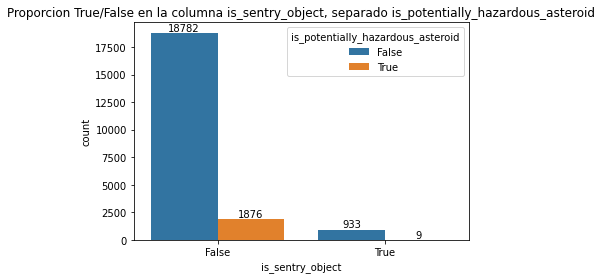

In [129]:
ax = sns.countplot(data = df_united, x = 'is_sentry_object', hue = 'is_potentially_hazardous_asteroid')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.title('Proporcion True/False en la columna is_sentry_object, separado is_potentially_hazardous_asteroid')
plt.show()

Hay registros que son potencialmente peligrosos, pero que no se encuentran en el sistema de monitoreo Sentry

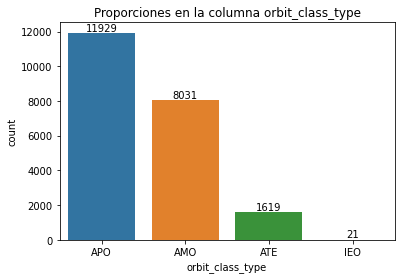

In [130]:
# Distribucion de categorias en columna 'orbit_class_type'

ax = sns.countplot(x = df_united['orbit_class_type'])
ax.bar_label(ax.containers[0])
plt.title('Proporciones en la columna orbit_class_type')
plt.show()

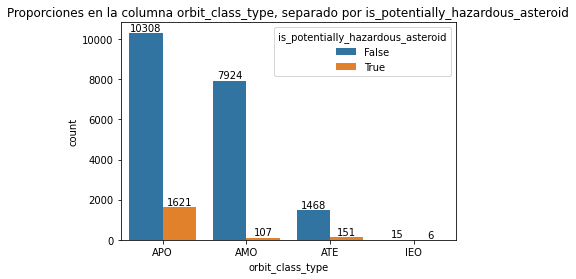

In [131]:
ax = sns.countplot(data = df_united, x = 'orbit_class_type', hue = 'is_potentially_hazardous_asteroid')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.title('Proporciones en la columna orbit_class_type, separado por is_potentially_hazardous_asteroid')
plt.show()

### Distribución de variables continuas

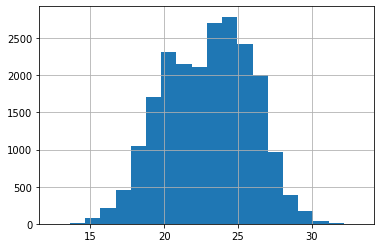

In [132]:
# Distribucion de valores de la columna 'absolute_magnitude_h'

df_united['absolute_magnitude_h'].hist(bins = 20)
plt.show()

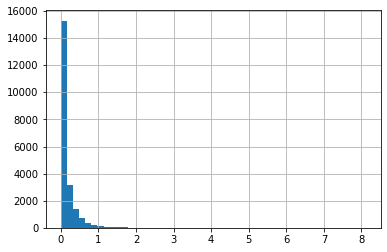

In [133]:
# Distribucion de valorea de la columna 'kilometers_estimated_diameter_min'

df_united['kilometers_estimated_diameter_min'].hist(bins=50)
plt.show()

# El mayor valor registrado es 8.1013048824

Se acotan superiormente los valores de la columna para graficar y ver mejor la distribución, ya que presenta un marcado sesgo positivo

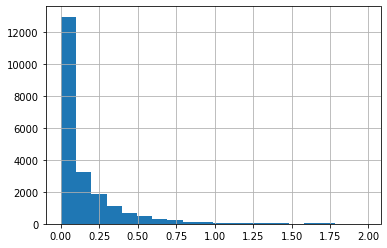

In [134]:
df_united[df_united['kilometers_estimated_diameter_min'] < 2]['kilometers_estimated_diameter_min'].hist(bins=20)
plt.show()

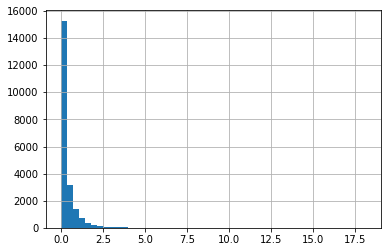

In [135]:
# distribucion de valores de la columna 'kilometers_estimated_diameter_max'

df_united['kilometers_estimated_diameter_max'].hist(bins=50)
plt.show()

# El mayor valor registrado es 18.1150684236

Igual que antes, se acotan los valores para poder apreciar mejor la grafica, debido al marcado sesgo positivo de la distribución

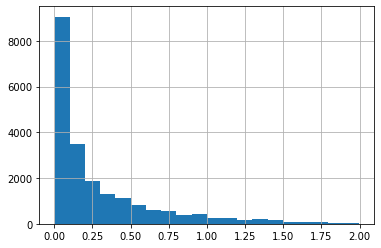

In [136]:

df_united[df_united['kilometers_estimated_diameter_max'] < 2]['kilometers_estimated_diameter_max'].hist(bins=20)
plt.show()

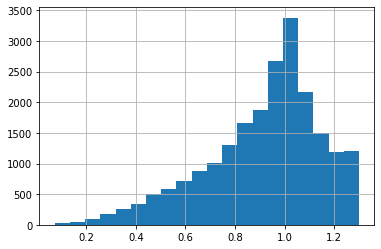

In [137]:
# Distribucion de valores de la columna 'perihelion_distance'

df_united['perihelion_distance'].hist(bins=20)
plt.show()

# La distribucion de esta columna en cambio presenta sesgo negativo

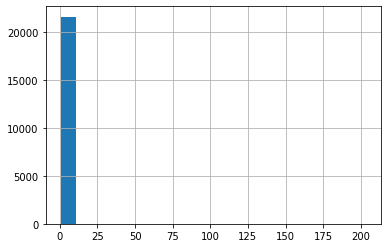

In [138]:
# Distribucion de valores de la columna 'aphelion_distance'

df_united['aphelion_distance'].hist(bins=20)
plt.show()

# El vmayor valor registrado es 631.8954563363584

Se acotan los valores de la columna para poder apreciar mejor la distribución

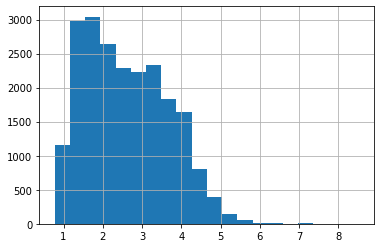

In [139]:

df_united[df_united['aphelion_distance'] < 10]['aphelion_distance'].hist(bins=20)
plt.show()

Efectivamente esta distribucion tambien presenta sesgo positivo

### Matriz de correlaciones

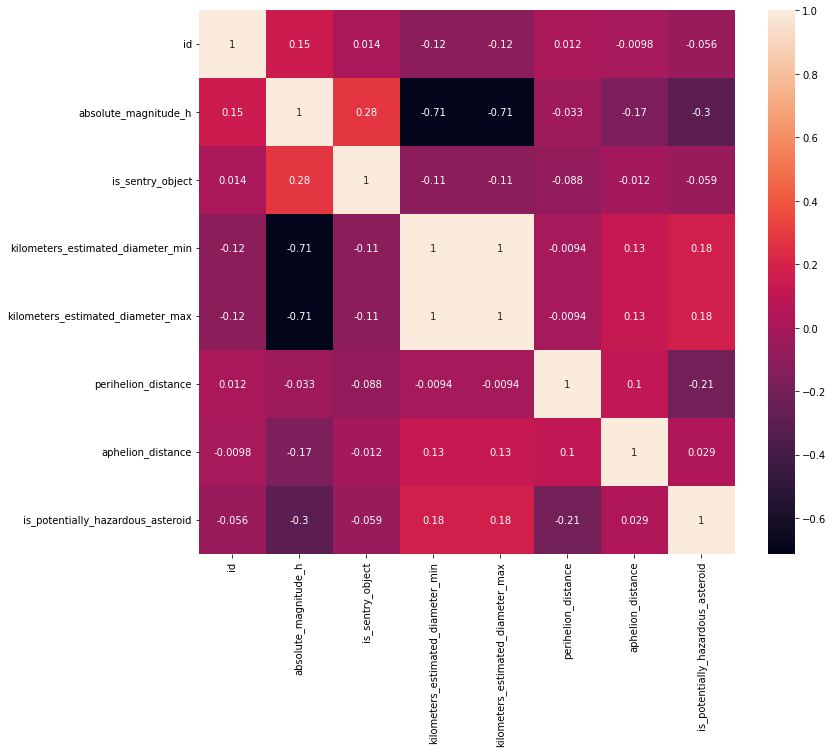

In [140]:
fig, ax = plt.subplots(figsize = (12,10))
sns.heatmap(df_united.corr(), annot = True, ax=ax)
plt.show()

In [141]:
df_united.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21600 entries, 17254 to 9134
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 21600 non-null  int64  
 1   name                               21600 non-null  object 
 2   absolute_magnitude_h               21592 non-null  float64
 3   is_sentry_object                   21600 non-null  bool   
 4   kilometers_estimated_diameter_min  21593 non-null  float64
 5   kilometers_estimated_diameter_max  21593 non-null  float64
 6   orbit_id                           21600 non-null  object 
 7   orbit_class_type                   21600 non-null  object 
 8   perihelion_distance                21600 non-null  float64
 9   aphelion_distance                  21600 non-null  float64
 10  first_observation_date             21600 non-null  object 
 11  last_observation_date              21600 non-null  

Nos interesa ver la correlacion con las variables 'orbit_class_type' y 'orbit_class_description', por lo que aplicamos las transformaciones necesarias para ello

In [142]:
# Codigo traido de la siguiente parte, alli esta bien explicadas las transformaciones 

df_united['orbit_class_type'] = pd.Categorical(df_united['orbit_class_type'])
df_united['orbit_class_type'] = df_united['orbit_class_type'].cat.codes

df_united['orbit_class_description'] = pd.Categorical(df_united['orbit_class_description'])
df_united['orbit_class_description'] = df_united['orbit_class_description'].cat.codes

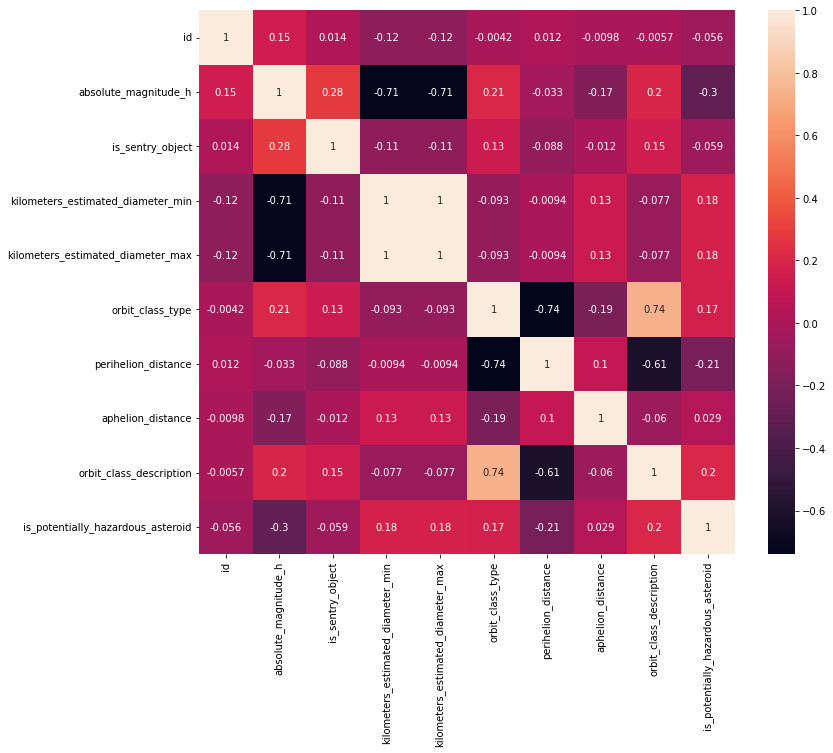

In [143]:
fig, ax = plt.subplots(figsize = (12,10))
sns.heatmap(df_united.corr(), annot = True, ax=ax)
plt.show()

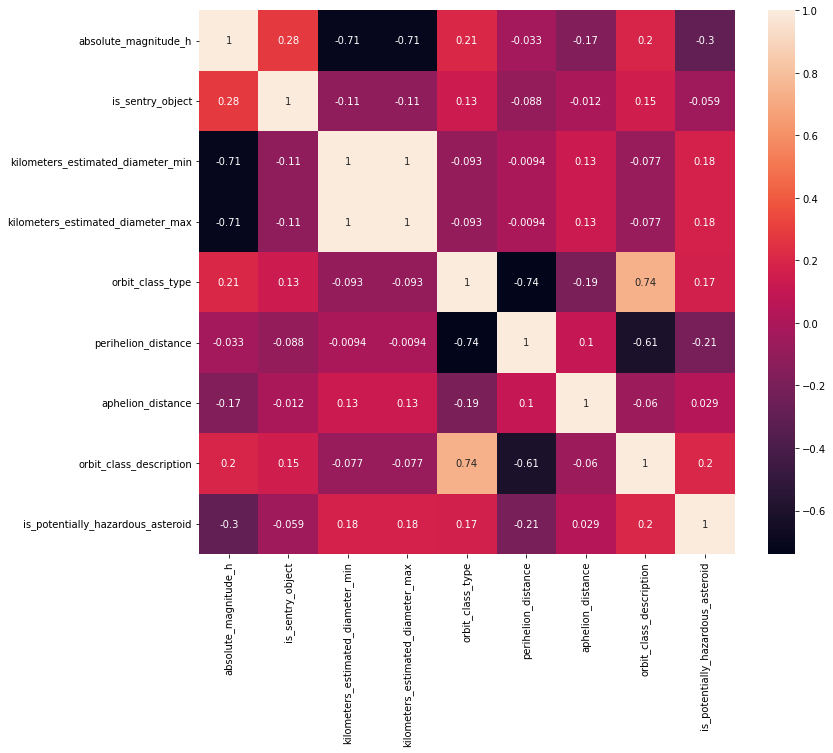

In [146]:
# Buscar correlaciones con la columna de identificacion (id) no tiene sentido asi que volvemos a hacer la correlacion sin ella

df_wo_ids = df_united.drop(columns = ['id'])

fig, ax = plt.subplots(figsize = (12,10))
sns.heatmap(df_wo_ids.corr(), annot = True, ax=ax)
plt.show()

### Pairplot

In [148]:
df_united.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21600 entries, 17254 to 9134
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 21600 non-null  int64  
 1   name                               21600 non-null  object 
 2   absolute_magnitude_h               21592 non-null  float64
 3   is_sentry_object                   21600 non-null  bool   
 4   kilometers_estimated_diameter_min  21593 non-null  float64
 5   kilometers_estimated_diameter_max  21593 non-null  float64
 6   orbit_id                           21600 non-null  object 
 7   orbit_class_type                   21600 non-null  int8   
 8   perihelion_distance                21600 non-null  float64
 9   aphelion_distance                  21600 non-null  float64
 10  first_observation_date             21600 non-null  object 
 11  last_observation_date              21600 non-null  

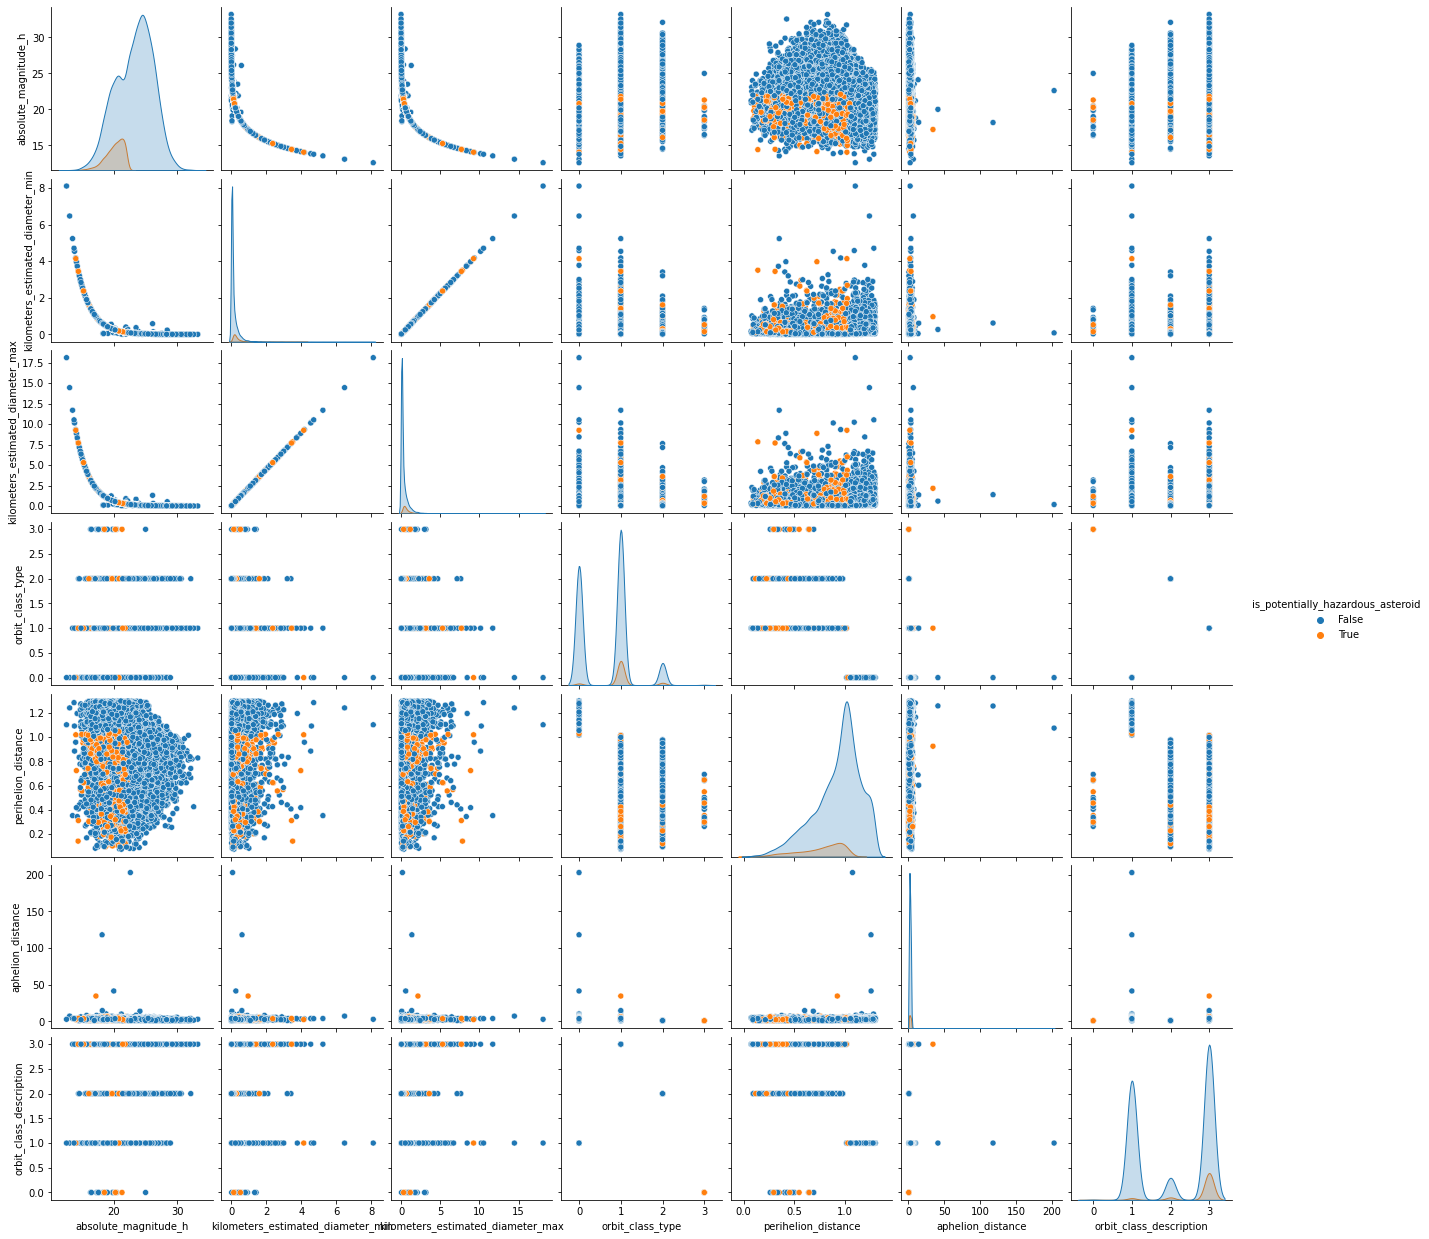

In [154]:
# se sacan las variables de tipo object y bool que no interesan para el pairplot
df_for_pairplot = df_united.drop(columns = ['is_sentry_object','id', 'name', 'orbit_id', 'first_observation_date', 'last_observation_date'])

sns.pairplot(data = df_for_pairplot , hue = 'is_potentially_hazardous_asteroid')

In [151]:
df_for_pairplot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21600 entries, 17254 to 9134
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   absolute_magnitude_h               21592 non-null  float64
 1   is_sentry_object                   21600 non-null  bool   
 2   kilometers_estimated_diameter_min  21593 non-null  float64
 3   kilometers_estimated_diameter_max  21593 non-null  float64
 4   orbit_class_type                   21600 non-null  int8   
 5   perihelion_distance                21600 non-null  float64
 6   aphelion_distance                  21600 non-null  float64
 7   orbit_class_description            21600 non-null  int8   
 8   is_potentially_hazardous_asteroid  21600 non-null  bool   
dtypes: bool(2), float64(5), int8(2)
memory usage: 1.6 MB


## Transformacion de datos

- Vamos a convertir a datatime dtype a las columnas 'first_observation_date' y 'last_observation_date'

- Las columnas 'is_potentially_hazardous_asteroid' y 'is_sentry_object' se encodean en 0 y 1

- La columna 'orbit_class_type' puede encodearse en 0, 1, 2 y 3 por tener 4 categorias diferentes

- La columnas 'orbit_id' podrían pasarse a tipo numerico, verificarlo

- Analizar columna 'orbit_class_description'

- Analizar columnas 'kilometers_estimated_diameter_min' y 'kilometers_estimated_diameter_max' para evaluar si las podemos condensar en una sola

- Estandarizar todas las variables continuas (MinMaxScaler)

- Transformar variables de kilometros a metros


Comentario: todo se va a aplicar en primera instancia a df_raw, luego se crea el Pipeline para pasar las divisiones (train, valid y test)

In [86]:
# df_raw['first_observation_date'] = pd.to_datetime(df_raw['first_observation_date']) - Error: Unknown string format: 2008-??-??


Hay un valor en la columna 'first_observation_date' que vale '2008-??-??', por lo cual no es posible convertirlo a datetime tipo de dato. Entonces procedemos a borrar ese registro

In [87]:
df_raw[df_raw['first_observation_date'] == '2008-??-??']

,id,name,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_id,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
20702,3843794,(2019 RN1),20.6,False,False,0.20163,0.450858,MPO508629,AMO,1.077174,1.865083,2008-??-??,2019-09-06,Near-Earth asteroid orbits similar to that of ...



El registro a eliminar corresponde a la categoria mayoritaria de la columna 'is_potentially_hazardous_asteroid' 

In [88]:
df_raw = df_raw.drop(df_raw[df_raw['first_observation_date'] == '2008-??-??'].index[0])

Transformando a datetime tipo de dato

In [89]:
df_raw['first_observation_date'] = pd.to_datetime(df_raw['first_observation_date'])
df_raw['last_observation_date'] = pd.to_datetime(df_raw['last_observation_date'])

Transformacion a 0 y 1 de las columnas 'is_potentially_hazardous_asteroid' y 'is_sentry_object'

In [90]:
df_raw['is_potentially_hazardous_asteroid'] = pd.Categorical(df_raw['is_potentially_hazardous_asteroid'])
df_raw['is_potentially_hazardous_asteroid'] = df_raw['is_potentially_hazardous_asteroid'].cat.codes

df_raw['is_sentry_object'] = pd.Categorical(df_raw['is_sentry_object'])
df_raw['is_sentry_object'] = df_raw['is_sentry_object'].cat.codes

Transformando las categorias de 'orbit_class_type' a 0, 1, 2 y 3

In [91]:
df_raw['orbit_class_type'] = pd.Categorical(df_raw['orbit_class_type'])
df_raw['orbit_class_type'] = df_raw['orbit_class_type'].cat.codes

Verificando valores de la columna 'orbit_id' para analizar

In [92]:
df_raw['orbit_id'].sample(10)

16989      9
12315     21
1591     189
6507       8
23047      6
12585      7
2923      21
23758      3
22611      3
12240      5
Name: orbit_id, dtype: object

Se chequea si todos los valores de esta columna son numéricos

In [93]:
df_raw[np.logical_not(df_raw['orbit_id'].str.isnumeric())]


,id,name,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_id,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
10055,3645194,(2013 NE24),27.3,0,0,0.009216,0.020608,E2021-CI3,1,0.944657,4.634736,2013-07-14,2013-07-15,Near-Earth asteroid orbits which cross the Ear...
14813,3759689,(2016 RM41),25.3,0,0,0.023150,0.051765,MPO392510,0,1.050360,4.923787,2016-09-10,2016-09-11,Near-Earth asteroid orbits similar to that of ...


El dataset contiene solamente dos valores no numericos en la columna orbit_id, y ademas pertenecen a la categoria mayoritaria de nuestro target, por lo que podemos eliminarlas

In [94]:
df_raw = df_raw.drop(df_raw[df_raw['orbit_id'] == 'E2021-CI3'].index[0])
df_raw = df_raw.drop(df_raw[df_raw['orbit_id'] == 'MPO392510'].index[0])

# df_raw['orbit_id'] = pd.to_numeric(df_raw['orbit_id'])

Terminar de transformar a cateorica las columnas 'name' y 'orbit_class_description'

In [95]:
df_raw['name'] = pd.Categorical(df_raw['name'])
df_raw['orbit_class_description'] = pd.Categorical(df_raw['orbit_class_description'])

Vamos a hacer un analisis de la columna 'orbit_class_description' para observar las descripciones y evaluar si pueden haber aportes valiosos de informacion

In [96]:
df_raw['orbit_class_description'].unique()

['Near-Earth asteroid orbits which cross the Ea..., 'Near-Earth asteroid orbits similar to that of..., 'Near-Earth asteroid orbits similar to that of..., 'An asteroid orbit contained entirely within t...]
Categories (4, object): ['An asteroid orbit contained entirely within t..., 'Near-Earth asteroid orbits similar to that of..., 'Near-Earth asteroid orbits similar to that of..., 'Near-Earth asteroid orbits which cross the Ea...]

La columna solo contiene 4 tipos de descripciones, entonces vamos a encodearla

In [97]:
df_raw['orbit_class_description'] = df_raw['orbit_class_description'].cat.codes

Procedemos a transformar las variables que estan en kilometros a metros

In [98]:
df_raw['kilometers_estimated_diameter_min'] = df_raw['kilometers_estimated_diameter_min']*1000
df_raw['kilometers_estimated_diameter_max'] = df_raw['kilometers_estimated_diameter_max']*1000

df_raw.rename(columns = {'kilometers_estimated_diameter_min':'meters_estimated_diameter_min'}, inplace = True)
df_raw.rename(columns = {'kilometers_estimated_diameter_max':'meters_estimated_diameter_max'}, inplace = True)

Vamos a introducir una nueva variable, calculada a partir del diámetro. Esta será el volumen del cuerpo, aproximando su forma a un elipsoide  
(volumen_elipsoide = (4/3) * $\pi$ * a * b * c)

In [99]:
import math

df_raw['volume (m^3)'] = (4/3)*math.pi*((df_raw['meters_estimated_diameter_min']/2)**2)*(df_raw['meters_estimated_diameter_max']/2)

In [100]:
df_raw['volume (m^3)'].describe()

count    2.398900e+04
mean     2.304746e+08
std      5.140065e+09
min      2.643313e-01
25%      1.667818e+04
50%      2.643313e+05
75%      8.956711e+06
max      6.225132e+11
Name: volume (m^3), dtype: float64

Las columnas 'meters_estimated_diameter_min' y 'meters_estimated_diameter_max' presentan las mismas correlaciones con las demas variables, visto en la matriz de correlaciones. Como el dataset esta desbalanceado, vamos a estudiar por separado que sucede con los registros donde el target es true y por otra parte con los que son false.

In [104]:
diff_true = df_raw[df_raw['is_potentially_hazardous_asteroid'] == True]['meters_estimated_diameter_max'] - df_raw[df_raw['is_potentially_hazardous_asteroid'] == True]['meters_estimated_diameter_min']
diff_true.describe()

<class 'pandas.core.series.Series'>
Int64Index: 2094 entries, 0 to 23919
Series name: None
Non-Null Count  Dtype  
--------------  -----  
2093 non-null   float64
dtypes: float64(1)
memory usage: 32.7 KB


In [105]:
diff_false = df_raw[df_raw['is_potentially_hazardous_asteroid'] == False]['meters_estimated_diameter_max'] - df_raw[df_raw['is_potentially_hazardous_asteroid'] == False]['meters_estimated_diameter_min']
diff_false.describe()

<class 'pandas.core.series.Series'>
Int64Index: 21903 entries, 1 to 23999
Series name: None
Non-Null Count  Dtype  
--------------  -----  
21896 non-null  float64
dtypes: float64(1)
memory usage: 342.2 KB


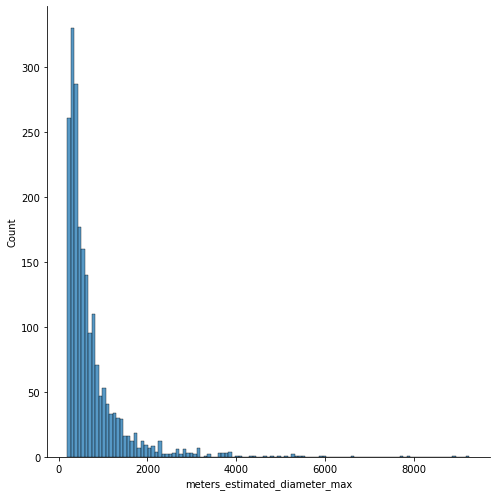

In [106]:
sns.displot(data = df_raw[df_raw['is_potentially_hazardous_asteroid'] == True]['meters_estimated_diameter_max'], height=7)
plt.show()

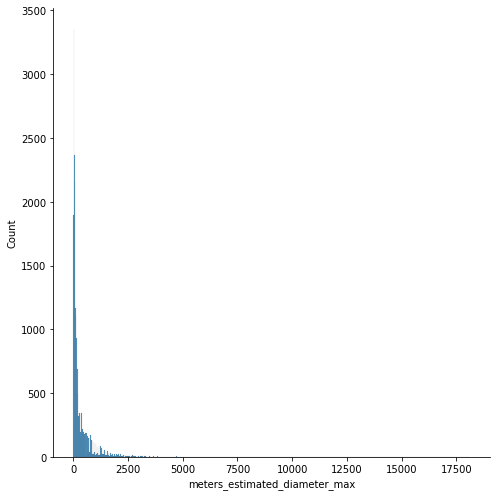

In [107]:
sns.displot(data = df_raw[df_raw['is_potentially_hazardous_asteroid'] == False]['meters_estimated_diameter_max'], height=7)
plt.show()

<AxesSubplot:>

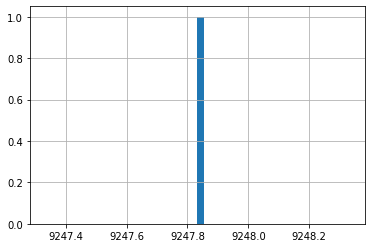

In [108]:
df_raw[(df_raw['meters_estimated_diameter_max'] > 9000) & (df_raw['is_potentially_hazardous_asteroid'] == True)]['meters_estimated_diameter_max'].hist(bins=50)

In [109]:
df_raw[df_raw['is_potentially_hazardous_asteroid'] == True]['meters_estimated_diameter_min'].describe()

count    2093.000000
mean      333.668162
std       343.619491
min        88.014652
25%       152.249185
50%       225.193047
75%       378.926498
max      4135.756649
Name: meters_estimated_diameter_min, dtype: float64

In [110]:
df_raw[df_raw['is_potentially_hazardous_asteroid'] == False]['meters_estimated_diameter_min'].describe()

count    21896.000000
mean       151.931907
std        282.669227
min          0.608913
25%         22.108281
50%         53.034072
75%        167.708462
max       8101.304882
Name: meters_estimated_diameter_min, dtype: float64

In [111]:
diff = df_raw['meters_estimated_diameter_max'] - df_raw['meters_estimated_diameter_min']
diff.describe()

count    23989.000000
mean       207.397485
std        362.186746
min          0.752657
25%         29.963831
50%         75.265739
75%        243.555158
max      10013.763541
dtype: float64

Corroboramos que la diferencia entre ambas columnas es muy pequeña, como habiamos mencionado anteriormente. Vamos a eliminar la columna kilometers_estimated_diameter_min y renombrar kilometers_estimated_diameter_max a kilometers_estimated_diameter

In [112]:
mean = (df_raw['meters_estimated_diameter_max'] + df_raw['meters_estimated_diameter_min'])/2

df_raw.drop(columns = ['meters_estimated_diameter_min'], inplace = True)
df_raw.rename(columns = {'meters_estimated_diameter_max':'meters_estimated_diameter'}, inplace = True)

*TODO: Aplicar pipeline a X_train, X_valid, X_test*

#### Observaciones:
(Consideramos fuerte correlacion por encima de 0.75 (o por debajo de -0.75))

No hay correlaciones fuertes respecto a nuestro target

Separamos nuestro dataset en entrenamiento, validación y prueba

Vamos a aplicar estandarizacion a las variables continuas (MinMaxScaler), estas son 'absolute_magnitude_h', 'meters_estimated_diameter', 'perihelion_distance' y 'aphelion_distance'

In [113]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() #se puede guardar como modelo
scaler.fit(X_train[['absolute_magnitude_h', 'meters_estimated_diameter', 'perihelion_distance', 'aphelion_distance']]) #solo con train

df_raw[['absolute_magnitude_h', 'meters_estimated_diameter', 'perihelion_distance', 'aphelion_distance']] = scaler.transform(df_raw[['absolute_magnitude_h', 'meters_estimated_diameter', 'perihelion_distance', 'aphelion_distance']])

KeyError: "['meters_estimated_diameter'] not in index"

In [ ]:
df_raw.to_csv('../data/df_proccessed.csv')
df = df_raw.copy()

In [ ]:
# , 'name', 'id', 'first_observation_date', 'last_observation_date' esto para sacar las variables que no me sirven para las predicciones y entrenamiento

Las columnas 'absolute_magnitude_h', 'kilometers_estimated_diameter_min' y 'kilometers_estimated_diameter_max' presentan valores faltantes. Se procede a llenarlos con las mediana de su columna correspondiente solo en el dataset de entrenamiento

In [ ]:
# Sustituyendo los valores faltantes de las columnas 'absolute_magnitude_h', 'kilometers_estimated_diameter_min'
# y 'kilometers_estimated_diameter_max' por sus respectivas medianas
# Esto porque las columnas 'kilometers_estimated_diameter_min' y 'kilometers_estimated_diameter_max' presentan distribuciones
# con sesgo positivo importante.

# ESTO SE APLICA A TRAIN Y VALID !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

imputer_median1 = SimpleImputer(strategy='median', missing_values=np.nan)
df_raw['absolute_magnitude_h'] = imputer_median1.fit_transform(df_raw[['absolute_magnitude_h']])

imputer_median2 = SimpleImputer(strategy='median', missing_values=np.nan)
df_raw['meters_estimated_diameter'] = imputer_median2.fit_transform(df_raw[['meters_estimated_diameter']])

In [ ]:
# Funciones

def modelAnalysis(clf,y_pred):
    sns.heatmap(confusion_matrix(y_valid,y_pred), annot= True , fmt='d')
    plt.show()
    print(f'Accuraccy score: {accuracy_score(y_valid,y_pred)}')
    print(f'classification report: \n{classification_report(y_valid,y_pred)}')

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(clf, X_united, y_united, scoring='roc_auc', cv=cv, n_jobs=-1)
    print('Mean ROC AUC: %.3f' % np.mean(scores))

In [ ]:
################################################################################################################

## Problema del dataset desbalanceado

Primero entrenaremos los modelos con la proporción original del dataset, de esta manera tendremos un punto de referencia a la hora de evaluar las diferentes tecnicas de balanceo a estudiar.

### Random Forest sin balanceo previo

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [ ]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_valid)

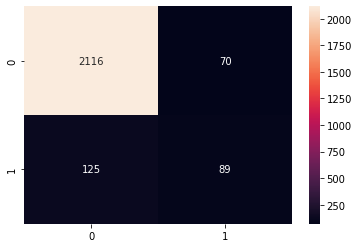

Accuraccy score: 0.91875
classification report: 
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2186
           1       0.56      0.42      0.48       214

    accuracy                           0.92      2400
   macro avg       0.75      0.69      0.72      2400
weighted avg       0.91      0.92      0.91      2400

Mean ROC AUC: 0.950


In [ ]:
modelAnalysis(clf,y_pred)

In [ ]:
# Los datos en principio dan bien, pero se puede apreciar el peso que tiene en la precision de la categoria 1 el tema de que el dataset sea desbalanceado

### Logistic Regression sin balanceo previo

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

#### Elegimos las features mas imporantes con RFECV

In [ ]:
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='roc_auc')
rfecv.fit(X_train, y_train)

/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

RFECV(cv=10, estimator=LogisticRegression(), scoring='roc_auc')

In [ ]:
print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X_train.columns[rfecv.support_]))
print(f'{rfecv.grid_scores_}')
print(f'{X_train.columns}')

Optimal number of features: 8
Selected features: ['absolute_magnitude_h', 'is_sentry_object', 'kilometers_estimated_diameter', 'orbit_id', 'orbit_class_type', 'perihelion_distance', 'aphelion_distance', 'orbit_class_description']
[[0.81617208 0.82142795 0.82556505 0.80570664 0.82394026 0.8043443
  0.82237935 0.82839101 0.79830276 0.80078174]
 [0.81676065 0.81995683 0.82553225 0.80511267 0.82228956 0.80492446
  0.82373651 0.82875061 0.79948926 0.80214891]
 [0.9126323  0.89829405 0.89381507 0.88930502 0.89450747 0.89065527
  0.89292757 0.90426482 0.8920419  0.88046175]
 [0.91147946 0.90482776 0.8912009  0.8957593  0.89571268 0.89108694
  0.89144608 0.90480335 0.89382079 0.8824491 ]
 [0.91177808 0.90466891 0.89137702 0.89512734 0.89468704 0.89116291
  0.8914599  0.90471823 0.89307727 0.88228059]
 [0.91294655 0.90540965 0.89210049 0.89585427 0.89476992 0.8918484
  0.89208668 0.90552776 0.89323188 0.88244736]
 [0.9129535  0.9054062  0.89209013 0.89585427 0.89476992 0.89183804
  0.89074333 0

/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


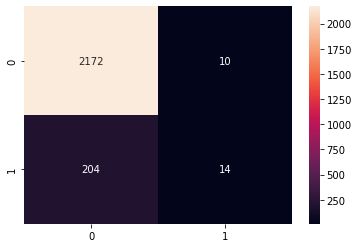

Accuraccy score: 0.9108333333333334
classification report: 
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2182
           1       0.58      0.06      0.12       218

    accuracy                           0.91      2400
   macro avg       0.75      0.53      0.53      2400
weighted avg       0.88      0.91      0.88      2400

Mean ROC AUC: 0.898


In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_valid)


sns.heatmap(confusion_matrix(y_valid,y_pred), annot= True , fmt='d')
plt.show()

print(f'Accuraccy score: {accuracy_score(y_valid,y_pred)}')
print(f'classification report: \n{classification_report(y_valid,y_pred)}')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf, X_united, y_united, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))



##### Ahora aplicaremos diferentes tecnicas de balanceo al dataset, relativas a Random Forest y Logistic Regression.
Fuente: https://www.aprendemachinelearning.com/clasificacion-con-datos-desbalanceados/
Fuente: https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/

#### Relativo a Logistic Regression

/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

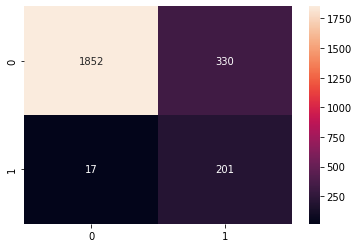

Accuraccy score: 0.8554166666666667
classification report: 
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      2182
           1       0.38      0.92      0.54       218

    accuracy                           0.86      2400
   macro avg       0.68      0.89      0.73      2400
weighted avg       0.94      0.86      0.88      2400

Mean ROC AUC: 0.904


In [ ]:
#1)Penalizacion

lr_pen = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced", max_iter=10000)
lr_pen.fit(X_train, y_train)

pred_y = lr_pen.predict(X_valid)
modelAnalysis(lr_pen, pred_y)

Distribution before resampling Counter({0: 17527, 1: 1670})
Distribution after resampling Counter({0: 5566, 1: 1670})


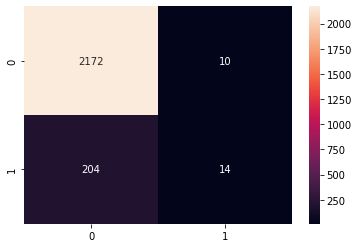

Accuraccy score: 0.9108333333333334
classification report: 
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2182
           1       0.58      0.06      0.12       218

    accuracy                           0.91      2400
   macro avg       0.75      0.53      0.53      2400
weighted avg       0.88      0.91      0.88      2400

Mean ROC AUC: 0.898


In [ ]:
# 2) Subsampling en la clase mayoritaria

from collections import Counter
from imblearn.under_sampling import NearMiss

us = NearMiss(sampling_strategy=0.3, n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print(f"Distribution before resampling {Counter(y_train)}")
print(f"Distribution after resampling {Counter(y_train_res)}")
 
lr_us = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
lr_us.fit(X_train, y_train)
pred_y = lr_us.predict(X_valid)
modelAnalysis(lr_us, pred_y)

Distribution before resampling Counter({0: 17527, 1: 1670})
Distribution after resampling Counter({0: 17527, 1: 5258})


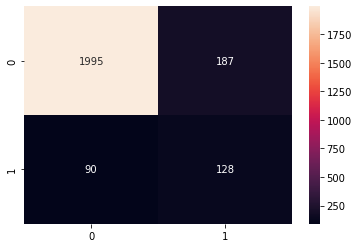

Accuraccy score: 0.8845833333333334
classification report: 
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      2182
           1       0.41      0.59      0.48       218

    accuracy                           0.88      2400
   macro avg       0.68      0.75      0.71      2400
weighted avg       0.91      0.88      0.89      2400

Mean ROC AUC: 0.898


In [ ]:
# 3) Oversampling de la clase minoritaria

from collections import Counter
from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler(sampling_strategy=0.3)
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print(f"Distribution before resampling {Counter(y_train)}")
print(f"Distribution after resampling {Counter(y_train_res)}")
 
lr_os = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
lr_os.fit(X_train_res, y_train_res)
pred_y = lr_os.predict(X_valid)
modelAnalysis(lr_os, pred_y)

In [ ]:
########################################################################################################################################

#### Relativo a Random Forest

In [ ]:
# 1) Class Weighting

# A simple technique for modifying a decision tree for imbalanced classification is to change
# the weight that each class has when calculating the “impurity” score of a chosen split point.
# Impurity measures how mixed the groups of samples are for a given split in the training dataset 
# and is typically measured with Gini or entropy. The calculation can be biased so that a mixture
#  in favor of the minority class is favored, allowing some false positives for the majority class.
# This modification of random forest is referred to as Weighted Random Forest.

clf = RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state=42)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf, X_united, y_united, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.920


In [ ]:
# 2) Bootstrap Class Weighting

# Given that each decision tree is constructed from a bootstrap sample 
# (e.g. random selection with replacement), the class distribution in 
# the data sample will be different for each tree. As such, it might be 
# interesting to change the class weighting based on the class distribution 
# in each bootstrap sample, instead of the entire training dataset. This can 
# be achieved by setting the class_weight argument to the value ‘balanced_subsample‘.

clf = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', random_state=42)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf, X_united, y_united, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.921


In [ ]:
# 3) Random Undersampling

# Another useful modification to random forest is to perform data resampling on the
#  bootstrap sample in order to explicitly change the class distribution. The 
# BalancedRandomForestClassifier class from the imbalanced-learn library implements 
# this and performs random undersampling of the majority class in reach bootstrap sample. 
# This is generally referred to as Balanced Random Forest.
from imblearn.ensemble import BalancedRandomForestClassifier

clf = BalancedRandomForestClassifier(n_estimators=10)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf, X_united, y_united, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.942


In [ ]:
# 4) Ensemble

# The Easy Ensemble involves creating balanced samples of the training dataset by selecting all examples
#  from the minority class and a subset from the majority class. Rather than using pruned decision trees, 
# boosted decision trees are used on each subset, specifically the AdaBoost algorithm. AdaBoost works by 
# first fitting a decision tree on the dataset, then determining the errors made by the tree and weighing 
# the examples in the dataset by those errors so that more attention is paid to the misclassified examples 
# and less to the correctly classified examples. A subsequent tree is then fit on the weighted dataset 
# intended to correct the errors. The process is then repeated for a given number of decision trees.

from imblearn.ensemble import EasyEnsembleClassifier

clf = EasyEnsembleClassifier(n_estimators=10)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf, X_united, y_united, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.951


## Aplicacion de Random Forest